In [24]:
import sys
from tkinter import EXCEPTION
sys.path.append('./includes')
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.linalg import norm
from math import sqrt, pow, ceil
from numba import njit

# import ray
# ray.init()

from includes.constants import *
from includes.calculations import *
# from includes.gpu_calculations import *
from includes.plotting import *

In [25]:

np.random.seed(42)

# Because temperature is an average kinetic energy of CHAOTIC movement, I'll need to substract
# the speed of center of mass from the speed of every atom to calculate the temperature


def main_cycle(spawn_on_grid=True, sigma_for_vel=0.5, verbose=1, bins_num=50, averaging_part=0.8, writing_step=1, device='CPU',
    coords_path='coords.csv', forces_path='forces.csv', vel_path='velocities.csv',
    boundary_conditions=True, boundary_conditions_teleportation=True, velocity_scaler=None):
    '''

    main cycle, all the movements and calculations will happen here
    verbose: % of program finished to print
    diffusion_step: once every diffusion_step all coordinates will be written for diffusion plotting
    rho = 1 / rho_coef ** 3

    boundary_conditions: овтечает за выбор частиц из других клеток при расчете сил, ЗСЭ при этом не будет выполняться, False ставим чтобы получить F(r), тогда частицы могут бешено разогнаться

    boundary_conditions_teleportation: отвечает за 'телепортацию' частицы к противоположному краю клетки, чтобы все было норм с ЗСЭ надо оба включать

    velocity_scaler: указываем температуру к которой скейлить
    
    '''
    if str(N) not in coords_path.split('.')[0] or str(N) not in forces_path.split('.')[0]:
        raise Exception('Writing into the wrong file (amount of particles)')

    particles = initialize_system(on_grid=spawn_on_grid, sigma_for_velocity=sigma_for_vel, device=device)
    total_pot = 0
    total_kin = 0
    #---
    energies = np.array([])
    kins = np.array([])
    pots = np.array([])
    #---
    coord_writer, force_writer, vel_writer = create_coords_and_forces_writer(coords_path=coords_path, forces_path=forces_path, vel_path=vel_path)
    steps_of_averaging = int(averaging_part * TIME_STEPS)
    #---
    for ts in range(TIME_STEPS):
        write_first_rows_in_files()
        total_pot = 0
        total_kin = 0
        #-----moving---------
        for p in particles:
            p.move(boundary_conditions_teleportation)
            p.kin_energy = 0.5 * norm(p.vel) ** 2
            write_into_the_files(p)
            p.vel = p.vel + 0.5 * p.acc * dt # adding 1/2 * a(t) * dt
            p.acc = np.zeros(3)
            p.pot_energy = 0
        for i in range(N):
            for j in range(i + 1, N):
                calculate_acceleration(particles[i], particles[j], boundary_conditions)
        for p in particles:
            total_kin += p.kin_energy
            total_pot += p.pot_energy
            p.vel += 0.5 * p.acc * dt   # adding 1/2 * a(t + dt)
        #---

        # energies = np.append(energies, total_kin + total_pot)
        # kins = np.append(kins, total_kin)
        # pots = np.append(pots, total_pot)      
        T_current = (2 / 3) * (total_kin) / N

        if velocity_scaler:
            for p in particles:
                p.vel *= sqrt(velocity_scaler / T_current)

        # Starting things for a set conditions:
        if (ts >= TIME_STEPS - steps_of_averaging) and (ts % writing_step == 0):

            write_coords_and_forces(particles=particles, time=ts * dt, coord_writer=coord_writer, force_writer=force_writer, vel_writer=vel_writer)

        #--------
        # if int((0.01 * TIME_STEPS)) % verbose == 0:
        #     print(f'{ts} steps passed, Temp_current = {T_current}, K={total_kin}, U={total_pot}, E = {total_kin + total_pot}')
            
    return particles


In [26]:

# ---------------------------------------- #

particles = main_cycle(
        spawn_on_grid=True,
        
        sigma_for_vel=0.5, bins_num=170, 
        
        averaging_part=0.95,
        
        writing_step=1,

        boundary_conditions=False,  # False, если хотим просто силы записывать
        # boundary_conditions_teleportation=False,     # Если скейлер ставить и здесь True, то никто очень сильно не разгонится
        # velocity_scaler=0.5,

        coords_path=f'coords{N}.csv',
        forces_path=f'forces{N}.csv',
        vel_path=f'velocities{N}.csv',
        verbose=1
        )

        # False, True, 0.5 - типичная настройка для записи сил


# Для каждой частицы мы берем разные 'копии' других частиц из соседних клеток, поскольку выбор оптимальных соседей для каждой частицы из главной клетки свой, 
# поэтому все что нам остается - отключить периодические условия, поскольку иначе в одной конфигурации мы можем определить силы только для одной частицы

# Но их можно отключить хитро: поскольку нас волнует только зависимость F(\vec {r}), то можно оставить телепортацию частиц при выходе из клетки, но отключить выбор частиц из других клеток при расчете сил

In [27]:
particles[0].pot_energy

-0.001967663850698897

In [28]:
# @njit
def pot_energy(r1, r2):
    r = r1 - r2
    print(r[0])
    for i in range(3):
        if np.abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
            r[i] = r[i] - L * sgn(r[i])
    dist = norm(r)
    return -4 * (pow(dist, -6) - pow(dist, -12))

In [29]:
r1 = particles[0].pos

In [30]:
r2 = particles[1].pos

In [31]:
def calculate_acceleration(part1, part2, boundary_conditions=True):
    r1 = part1.pos
    r2 = part2.pos
    r = r1 - r2
    # Boundary condition realisation:
    if boundary_conditions:
        for i in range(3):
            if abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
                r[i] = r[i] - L * sgn(r[i])
            
    dist = norm(r)
    if dist < r_cut:
        part1.acc += force(r) / M       # we add the force from only one particle acting on another to the total acc
        part2.acc -= force(r) / M
        # potential of two particle interaction, we need to add it to the total pot of one: Both have a half of the total
        print(
            -4 * (pow(dist, -6) - pow(dist, -12))
        )
        part1.pot_energy += -4 * (pow(dist, -6) - pow(dist, -12))
        part2.pot_energy += 0

In [32]:
pd.read_csv(f"coords2.csv")

,t,0x,0y,0z,1x,1y,1z
0,0.0050,2.502000,0.058305,0.030388,1.274386,2.474985,2.475341
1,0.0051,2.501960,0.058335,0.030411,1.274426,2.474955,2.475318
2,0.0052,2.501920,0.058364,0.030434,1.274466,2.474925,2.475296
3,0.0053,2.501880,0.058394,0.030457,1.274506,2.474895,2.475273
4,0.0054,2.501841,0.058424,0.030479,1.274546,2.474866,2.475250
...,...,...,...,...,...,...,...
945,0.0995,2.464289,0.086448,0.051875,1.312098,2.446842,2.453855
946,0.0996,2.464249,0.086478,0.051898,1.312137,2.446812,2.453832
947,0.0997,2.464209,0.086508,0.051920,1.312177,2.446782,2.453809
948,0.0998,2.464169,0.086537,0.051943,1.312217,2.446752,2.453787


---

In [33]:
pd.read_csv(f"velocities2.csv")

,t,0v_x,0v_y,0v_z,1v_x,1v_y,1v_z
0,0.0050,-0.399016,0.297720,0.227275,0.399016,-0.297720,-0.227275
1,0.0051,-0.399016,0.297721,0.227275,0.399016,-0.297721,-0.227275
2,0.0052,-0.399016,0.297721,0.227275,0.399016,-0.297721,-0.227275
3,0.0053,-0.399016,0.297721,0.227275,0.399016,-0.297721,-0.227275
4,0.0054,-0.399016,0.297721,0.227275,0.399016,-0.297721,-0.227275
...,...,...,...,...,...,...,...
945,0.0995,-0.399110,0.297911,0.227468,0.399110,-0.297911,-0.227468
946,0.0996,-0.399110,0.297911,0.227468,0.399110,-0.297911,-0.227468
947,0.0997,-0.399111,0.297911,0.227468,0.399111,-0.297911,-0.227468
948,0.0998,-0.399111,0.297911,0.227468,0.399111,-0.297911,-0.227468


In [34]:
@njit
def pot_energy(r1, r2, boundary_condtitions=True):
    d = norm(r1 - r2)
    return -4 * (pow(d, -6) - pow(d, -12))

def plot_energy(N=2, path_coords="coords2.csv", path_vels="velocities2.csv"):
    E = []
    try:
        coords = pd.read_csv(path_coords).drop(columns=["t"])
        vels = pd.read_csv(path_vels).drop(columns=["t"])
    except:
        coords = pd.read_csv(path_coords)
        vels = pd.read_csv(path_vels)
    
    for row_n in range(len(vels)):  # TODO: ЗДЕСЬ СТОИТ vels ПОТОМУ ЧТО У МЕНЯ ПОКА БАГА И В КООРДС НА ОДНУ СТРОЧКУ БОЛЬШЕ ПОЧЕМУ-ТО...
        V = 0
        T = 0
        for i in range(N):
            r_i = np.array(coords.iloc[row_n, (3 * i):(3 * i) + 3])

            for j in range(i + 1, N):
                r_j = np.array(coords.iloc[row_n, (3 * j):(3 * j) + 3])
                # print(r_i, r_j)
                V += pot_energy(r_i, r_j)
        

        T = ((vels.iloc[row_n]) ** 2).sum() / 2
        E.append(T + V)

        # print(
        #     f'{row_n}: K = {T}, V = {V}, E = {T + V}'
        # )

    plt.figure(figsize=(10, 10))
    plt.plot(
        [i for i in range(len(E))], E
    )
    # plt.xlabel()

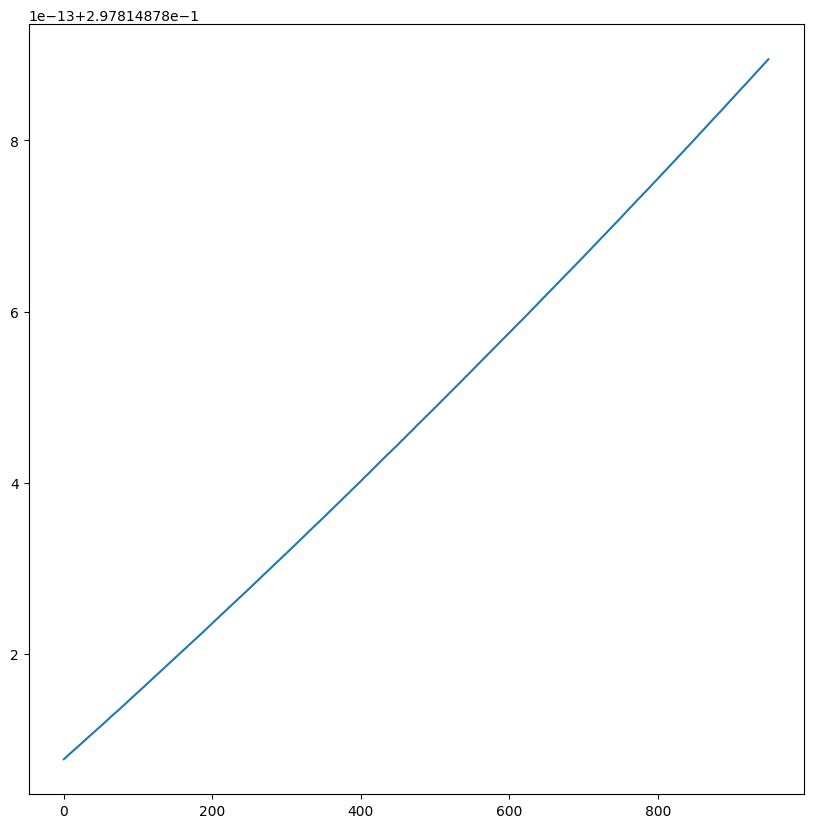

In [35]:
plot_energy()